In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy as sp
import h5py

import matplotlib.lines as mlines
from functools import reduce

sys.path.append('../methods/')

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Low-dim embedding 

In [2]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_1.0'
n = 5000
r = int(ind.split('_')[4])
d = int(ind.split('_')[2]) + r
noise = float(ind.split('_')[-1])
seed = 1
method = 'causarray_r_4'
path_data = path_base + 'data/simu_{}{}/'.format(n, ind)
path_result = path_base + 'results/simu_{}{}/'.format(n, ind)

filename = path_data+'simu_data_{}.h5'.format(seed)

with h5py.File(filename, 'r') as f:
    A = np.array(f['A'], dtype='float')
    W_all = np.array(f['W'], dtype='float')
    W = W_all[:, :-1]
    W[:,1:] = (W[:,1:] - np.mean(W[:,1:], axis=0, keepdims=True)) / np.std(W[:,1:], axis=0, ddof=1, keepdims=True)
    Y = np.array(f['Y'], dtype='float')
    Y = np.minimum(Y, np.quantile(np.max(Y, axis=0), 0.999))
    celltype = np.array(f['metadata'], dtype='float')[:Y.shape[0],-1].astype(int)
    theta = np.array(f['theta'], dtype='float')

method = 'causarray_r_4'
CF = pd.read_csv('{}{}_cf_{}.csv'.format(path_result, method, seed), index_col=0).values

import scanpy as sc

def create_adata(X, obs_data, raw=True, n_comps=100):
    adata = sc.AnnData(
        X=X,
        obs=pd.DataFrame(
            data=obs_data,
            columns=['A', 'Z', 'celltype']
        ),
    )
    adata.obs['celltype'] = adata.obs['celltype'].astype(int).astype('category')
    
    if raw is True:
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    
    sc.tl.pca(adata, n_comps=n_comps)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata, n_components=2)
    
    return adata

# Create observation data once
obs_data = np.c_[A.reshape(-1,1), W_all[:,-1:], celltype.reshape(-1,1)]

# Create both AnnData objects
adata = create_adata(Y, obs_data)
adata_cf = create_adata(CF, obs_data, raw=False)


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


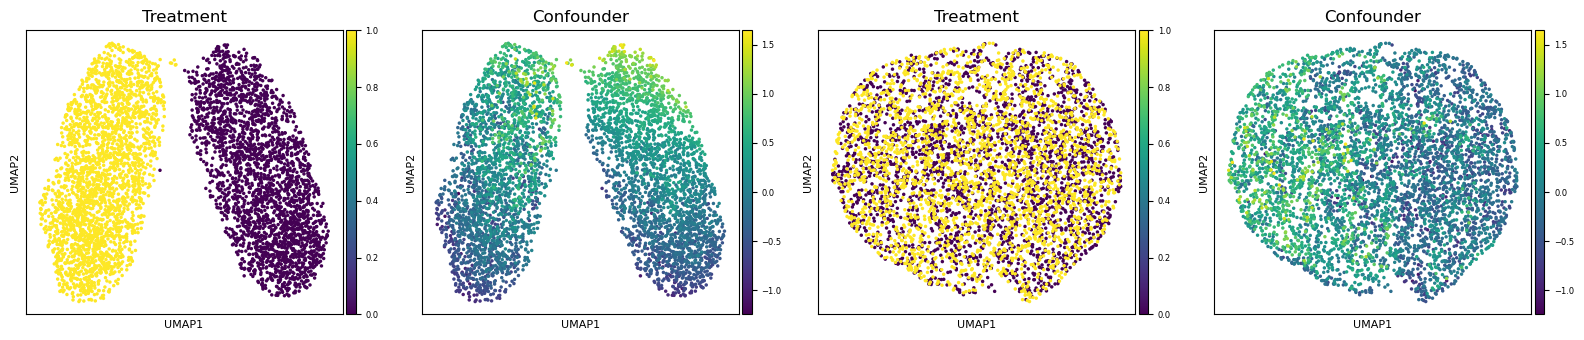

In [3]:

fig, axes = plt.subplots(1,4, figsize=(16,3.5))

axes[0] = sc.pl.umap(adata, color='A', s=25, ax=axes[0], show=False)
axes[2] = sc.pl.umap(adata_cf, color='A', s=25, ax=axes[2], show=False)

axes[1] = sc.pl.umap(adata, color='Z', s=25, ax=axes[1], show=False)
axes[3] = sc.pl.umap(adata_cf, color='Z', s=25, ax=axes[3], show=False)

for i in [0,2]:
    axes[i].set_title('Treatment')
    axes[i+1].set_title('Confounder')

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
    cbar.ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust the font size here
    cbar.ax.tick_params(axis='both', which='minor', labelsize=6)  # Adjust the font size for minor ticks if needed
fig.tight_layout()
plt.savefig('results/simu_poi_umap_AZ.pdf', dpi=300, bbox_inches='tight')


Processing method: causarray_r_4


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing method: ruv3nb_r_4


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing method: ruv_r_4


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing method: cinemaotw


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Processing method: cinemaot


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Processing method: cocoa


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing method: mixscape


/home/jinhongd/anaconda3/envs/causarray/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


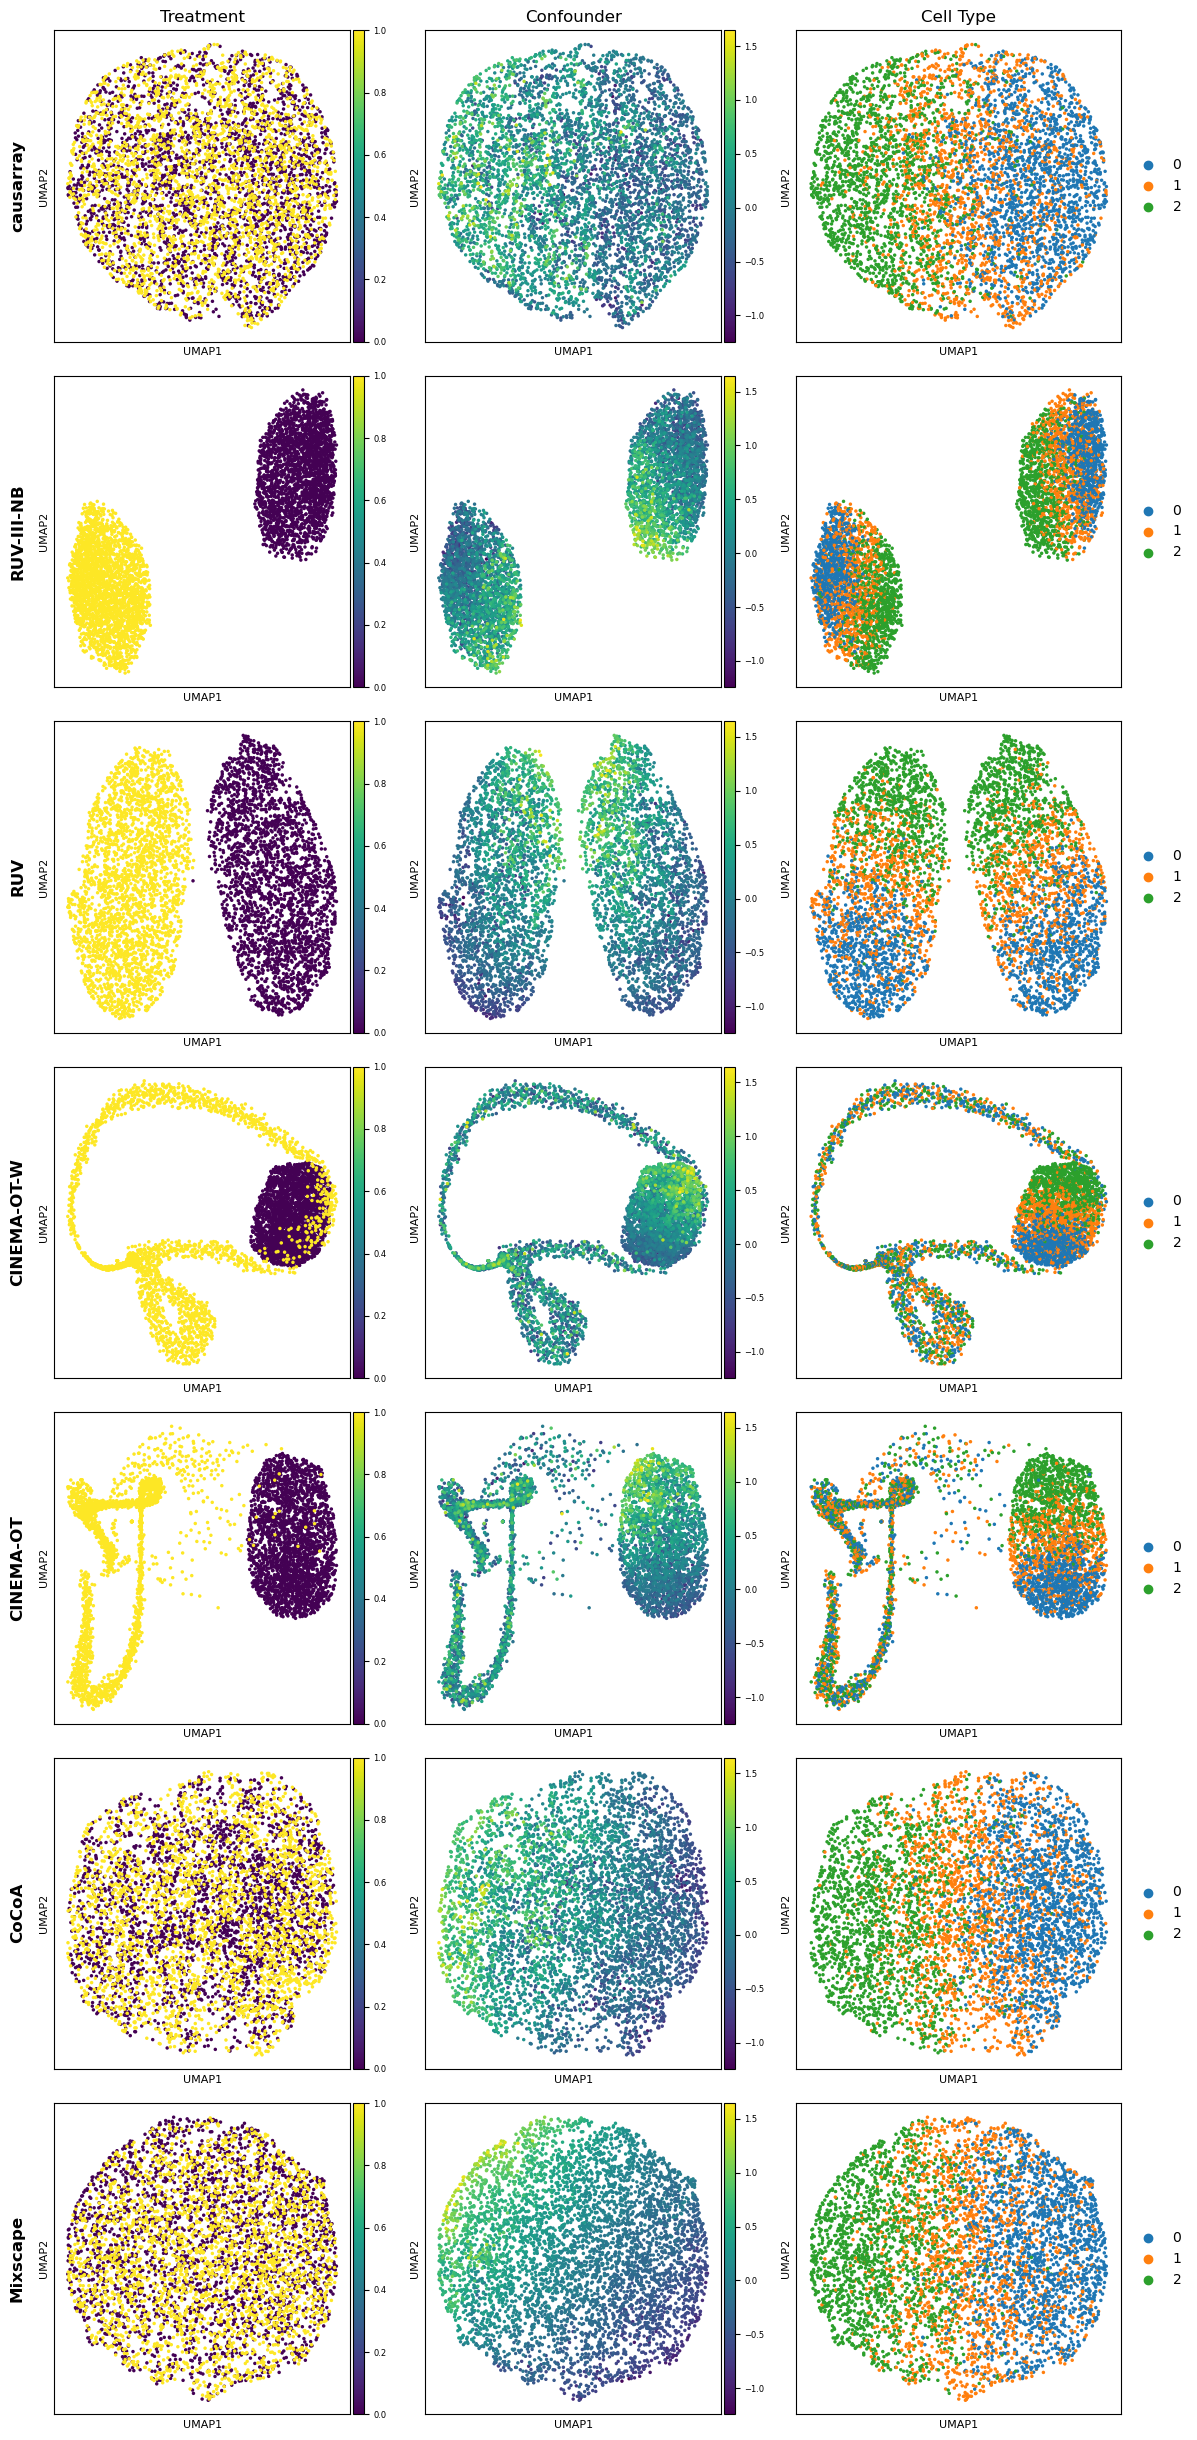

In [4]:
method_list = ['causarray_r_4', 'ruv3nb_r_4', 'ruv_r_4', 'cinemaotw', 'cinemaot', 'cocoa', 'mixscape']
adata_cf_dict = {}

for method in method_list:
    CF = pd.read_csv('{}{}_cf_{}.csv'.format(path_result, method, seed), index_col=0).values
    print(f'Processing method: {method}')
    adata_cf_dict[method] = create_adata(np.nan_to_num(CF), obs_data, raw=False)

method_name_list = ['causarray', 'RUV-III-NB', 'RUV', 'CINEMA-OT-W', 'CINEMA-OT', 'CoCoA', 'Mixscape']

fig, axes = plt.subplots(len(method_list), 3, figsize=(12,3.5*len(method_list)))

for i, method in enumerate(method_list):
    axes[i, 0] = sc.pl.umap(adata_cf_dict[method], color='A', s=25, ax=axes[i, 0], show=False)
    axes[i, 1] = sc.pl.umap(adata_cf_dict[method], color='Z', s=25, ax=axes[i, 1], show=False)
    axes[i, 2] = sc.pl.umap(adata_cf_dict[method], color='celltype', s=25, ax=axes[i, 2], show=False)

    
    if i==0:
        axes[i, 0].set_title('Treatment')
        axes[i, 1].set_title('Confounder')
        axes[i, 2].set_title('Cell Type')
    else:
        axes[i, 0].set_title('')
        axes[i, 1].set_title('')
        axes[i, 2].set_title('')

    for j in range(3):
        axes[i, j].set_xlabel(axes[i, j].get_xlabel(), fontsize=8)
        axes[i, j].set_ylabel(axes[i, j].get_ylabel(), fontsize=8)
    for j in range(2):
        cbar = axes[i, j].collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
        cbar.ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust the font size here
        cbar.ax.tick_params(axis='both', which='minor', labelsize=6)  # Adjust the font size for minor ticks if needed

    axes[i, 0].text(-0.15, 0.5, method_name_list[i], transform=axes[i, 0].transAxes, 
                    rotation=90, verticalalignment='center', fontsize=12, fontweight='bold')
fig.tight_layout()
plt.savefig('results/simu_poi_umap.pdf', dpi=300, bbox_inches='tight')


# Benchmarking with Poisson simulation

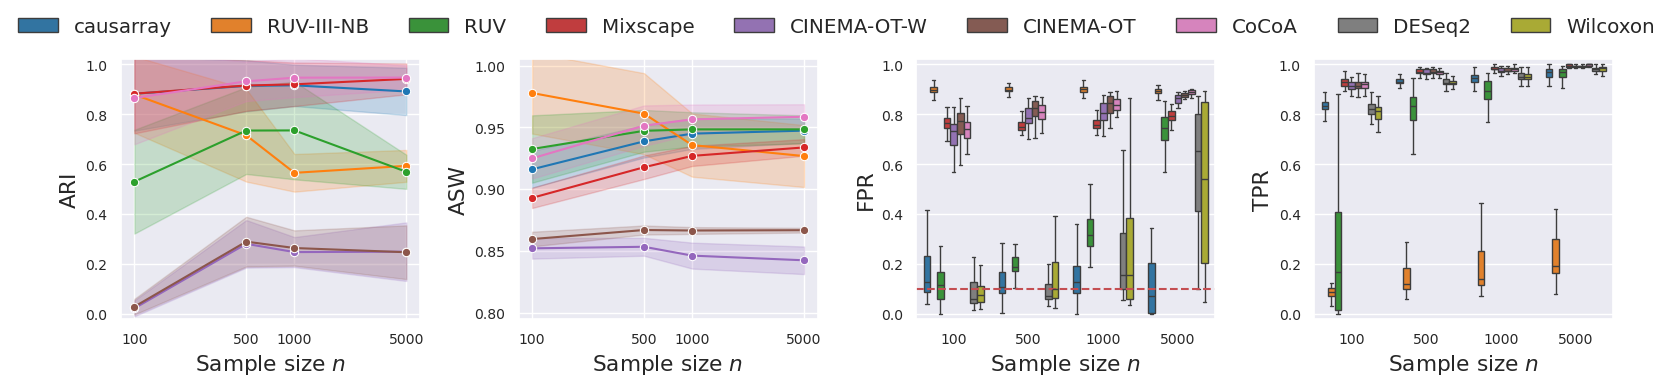

In [5]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_1.0'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [4]
n_list = [100, 500, 1000, 5000]

method_name = {
    'wilc':'Wilcoxon', 'DESeq':'DESeq2', 'cocoa':'CoCoA', 'cinemaot':'CINEMA-OT', 'cinemaotw':'CINEMA-OT-W', 'mixscape':'Mixscape'
    }
    
method_name.update(
    reduce(lambda a, b: dict(a, **b), 
    [{'ruv_r_{}'.format(r):'RUV' for r in r_list}, 
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB' for r in r_list}, 
      {'causarray_r_{}'.format(r):'causarray' for r in r_list} 
    ])
    )

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]


df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)
df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]

zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0. * zmax
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin) / (zmax - zmin)
df_cf[['ARI', 'ASW']] = np.clip(df_cf[['ARI', 'ASW']], 0, 1)

method_list = list(method_name.values())[::-1]
palette = sns.color_palette()[:len(method_list)]
hue_order = {i:c for i,c in zip(method_list, palette) }

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,4), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):    
    sns.lineplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j], palette=palette, marker='o', errorbar='sd')
    axes[j].set_xscale('log')
    axes[j].set_xticks(n_list)
    axes[j].set_xticklabels(n_list)

axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[-1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for j in range(4):
    if j != 1:
        axes[j].set_ylim(-0.02,1.02)
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
axes[1].set_ylim(0.8-0.005,1.005)
axes[1].set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.savefig(path_base + 'results/simu_poi{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)

# Sensitivity in $r$

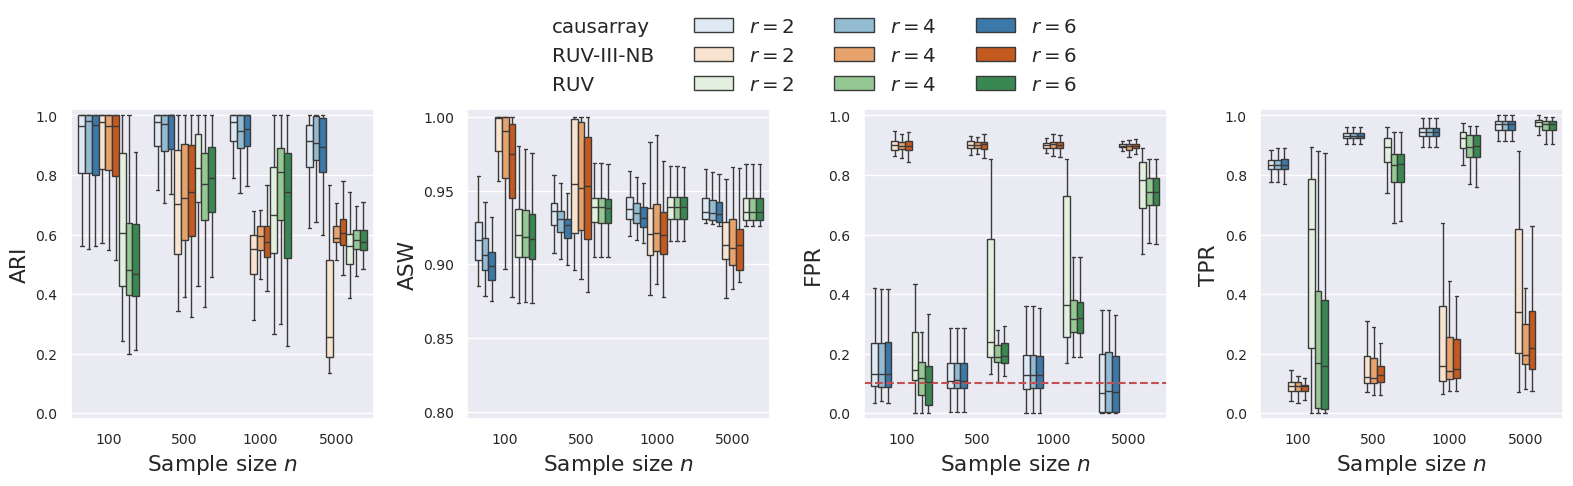

In [6]:
path_base = '/home/jinandmaya/simu_poi/'
ind = '_d_2_r_1_noise_1.0'

df_test = pd.read_csv(path_base+'results/result{}_test.csv'.format(ind)).rename({'FDR':'FPR', 'power':'TPR'}, axis=1)
df_cf = pd.read_csv(path_base+'results/result{}_deconfound.csv'.format(ind))

r_list = [2,4,6]
n_list = [100,500,1000,5000]
method_name = reduce(lambda a, b: dict(a, **b), 
    [{'causarray_r_{}'.format(r):'causarray $r={}$'.format(r) for r in r_list},
      {'ruv3nb_r_{}'.format(r):'RUV-III-NB $r={}$'.format(r) for r in r_list}, 
      {'ruv_r_{}'.format(r):'RUV $r={}$'.format(r) for r in r_list}
    ])

df_test = df_test[df_test['method'].isin(method_name.keys())]
df_cf = df_cf[df_cf['method'].isin(method_name.keys())]
df_test['method'] = df_test['method'].map(method_name)
df_cf['method'] = df_cf['method'].map(method_name)

df_test = df_test[df_test['n'].isin(n_list)]
df_cf = df_cf[df_cf['n'].isin(n_list)]

zmax = df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().max().values
zmin = 0.*df_cf.groupby(['n','method'])[['ARI', 'ASW']].median().min().values
df_cf[['ARI', 'ASW']] = (df_cf[['ARI', 'ASW']].values - zmin[None,:])/(zmax[None,:]-zmin[None,:])
df_cf[['ARI', 'ASW']] = np.clip(df_cf[['ARI', 'ASW']], 0, 1)

method_list = method_name.values()
palette = reduce(lambda l1, l2: l1+l2, [sns.color_palette(name)[:len(r_list)*2:2] for name in ['Blues', 'Oranges', 'Greens']])
hue_order = {i:c for i,c in zip(method_list, palette) }

sns.set(font_scale=1.3)
fig, axes = plt.subplots(1,4, figsize=(16,5), sharex=False, sharey=False)
for j, metric in enumerate(['FPR', 'TPR']):
    sns.boxplot(data=df_test, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j+2], palette=palette, showfliers=False)

for j, metric in enumerate(['ARI', 'ASW']):
    sns.boxplot(data=df_cf, x='n', y=metric, hue='method', hue_order=hue_order,
        ax=axes[j], palette=palette, showfliers=False
        )

axes[2].axhline(0.1, color='r', linestyle='--')
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[-1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
handles = [mlines.Line2D([], [], linestyle='None')] * 3 + handles[::3] + handles[1::3] + handles[2::3]
labels = ['causarray', 'RUV-III-NB', 'RUV',
            '$r=2$', '$r=2$', '$r=2$',
            '$r=4$', '$r=4$', '$r=4$',
            '$r=6$', '$r=6$', '$r=6$',
            ]

for j in range(4):
    if j != 1:
        axes[j].set_ylim(-0.02,1.02)
    else:
        axes[1].set_ylim(0.8-0.005,1.005)
        axes[1].set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
    axes[j].get_legend().remove()
    axes[j].tick_params(axis='both', which='major', labelsize=10)
    axes[j].set_xlabel('Sample size $n$')
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=4, title=None, frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig(path_base + 'results/simu_poi_r{}.pdf'.format(ind), bbox_inches='tight', pad_inches=0, dpi=300)